# Image Impeccable Challenge: Journey to Clarity

## Part 2 : Training Model

By: Leo Dinendra

---

This notebook is for training the model from scratch. 

Before running this notebook, make sure to execute **1_Data_Exploration_Analysis_Preparation.ipynb**. The output of this notebook will be checkpoint files, which are saved in the **checkpoint** folder.

### 0. General Setting

In [1]:
dataset_folder_path = './training_data_processed/'
checkpoint_name = 'unet_checkpoint_retrain'

In [2]:
num_epochs = 30         # number of training epoch
batch_size = 4          # batch size
learning_rate = 1e-3    # learning rate of adam optimizer
eta_min = 1e-6          # minimum learning rate of Cosine Annealing Scheduler
T_max = num_epochs      # when is the minimum learning rate will be, default is at the last epoch
perc_dataset = 0.95     # percent dataset used as training set
alpha = 0.5             # weight for combined loss of MSE+SSIM, the higher it is, the more in favor for MSE loss.

### 1. Import Packages, Preparing Dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from glob import glob
import os
#import pprint as pp
#from PIL import Image
#from datasets import Dataset
from torch.utils.data import DataLoader, Dataset
import cv2
from tqdm import tqdm
from utils import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR
from torchmetrics.image import StructuralSimilarityIndexMeasure

import logging
from skimage.metrics import structural_similarity as sk_ssim
from torchsummary import summary

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
seed = 83355
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [5]:
checkpoint_path = './checkpoint'
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

Getting the dataset files list.

In [6]:
seis_files = []
noise_files = []
for root, dirs, files in os.walk(dataset_folder_path):
    for file in files:
        if file.lower().endswith('.npy') and 'seismic' in file:
            full_path = os.path.join(root, file)
            seis_files.append(full_path)
        elif file.lower().endswith('.npy') and 'noise' in file:
            full_path = os.path.join(root, file)
            noise_files.append(full_path)

Putting it into Pytorch class dataset.

After trying multiple data augmentation and preprocessing techniques—such as rotation/zoom, frequency domain transformations, and seismic attribute, a raw normalized 2D slice, which can only be transformed by flipping horizontally, yielded the best results.

In [7]:
class TrainImageDataset(Dataset):
    def __init__(self, seis_files, noise_files, istest=False):
        """
        Args:
            seis_files (str): Directory with all the clean data.
            noise_files (str): Directory with all the noisy data.
        """
        self.seis_files = seis_files
        self.noise_files = noise_files
        self.istest = istest
        
    def __len__(self):
        return len(self.seis_files)

    def __getitem__(self, idx):
        
        seis2d = np.load(self.seis_files[idx], allow_pickle=True, mmap_mode="r+")
        noise2d = np.load(self.noise_files[idx], allow_pickle=True, mmap_mode="r+")
        
        if not self.istest:
            if np.random.rand() > 0.5:
                seis2d = np.fliplr(seis2d)
                noise2d = np.fliplr(noise2d)        
        
        seis2d = cv2.resize(seis2d, (320, 1280))
        noise2d = cv2.resize(noise2d, (320, 1280))
        
        seis_fft_tensor = torch.tensor(seis2d, dtype=torch.float32).unsqueeze(0)

        noise_fft_tensor = torch.tensor(noise2d, dtype=torch.float32).unsqueeze(0)
        return noise_fft_tensor, seis_fft_tensor

Splitting Training and Validation dataset.

As a seismic file set can generate 70 slices of training set files, the formula below is used to calculate the number of training splits to make sure there's no leaks.

In [8]:
training_number = int((len(seis_files)/70)*perc_dataset)*70

In [9]:
train_dataset = TrainImageDataset(seis_files[:training_number], noise_files[:training_number])
val_dataset = TrainImageDataset(seis_files[training_number:], noise_files[training_number:], istest=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Checking Data Loader if it works properly

In [10]:
sample_data, sample_label = train_dataset[0]

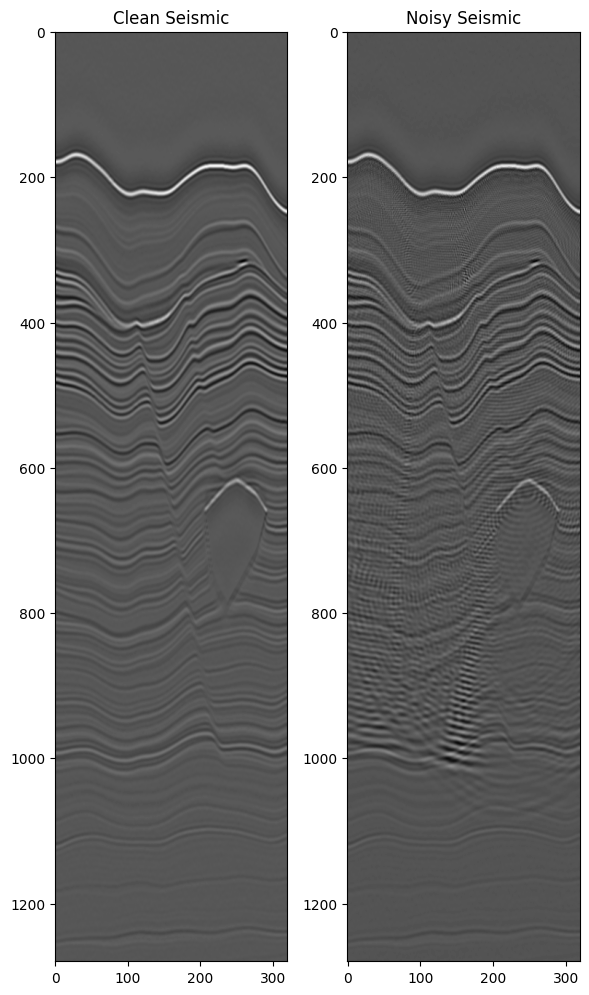

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 12))
ax[0].imshow(sample_label[0], cmap="gray")
ax[0].set_title("Clean Seismic")
ax[1].imshow(sample_data[0], cmap="gray")
ax[1].set_title("Noisy Seismic")
plt.tight_layout()
plt.show()

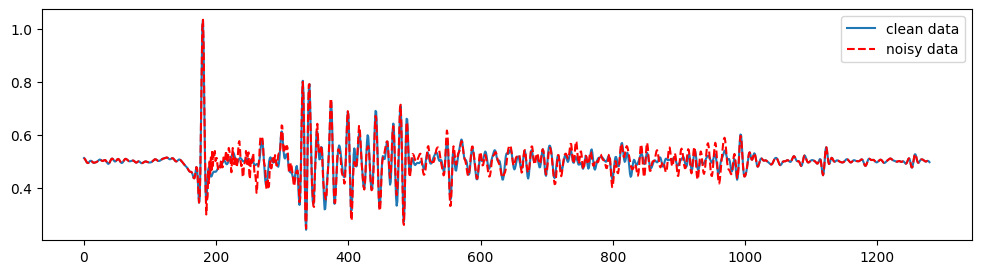

In [12]:
plt.figure(figsize=(12,3))
plt.plot(sample_label[0,:,0])
plt.plot(sample_data[0,:,0], '--r')
plt.legend(['clean data','noisy data'])
plt.show()

### 2. Preparing The Model Architecture

The Model is based on a UNet-like architecture, using the ResNet34 backbone as the encoder. Trained from scratch *(encoder_weights=None)*. The encoder has a customized depth of 4, set of channels—128, 64, 32, and 16—best result from experiments. Batch normalization is applied in the decoder for better training stability, and attention mechanisms *(decoder_attention_type='scse')* are added to improve focus on important features during reconstruction. Finally, the segmentation head is a custom Conv2d layer that outputs the denoised result with a 3x3 convolution, preserving spatial resolution.

Other models such as ViT+UNet, PSPNet, Unet++, PAN, and Mix Visual Transformer+FPN, have also been tested (for example, the ViT+Unet implementation is provided in the folder *other notebooks* for anyone who wants to tinker further). 

Yet, **ResNet34+scSE-UNet** delivered the best results in my experiments.

In [13]:
model = smp.Unet(
    encoder_name="resnet34",        # ResNet as the encoder backbone
    encoder_weights=None,           # start training from scratch for denoising
    in_channels=1,                  
    classes=1,                      
    encoder_depth=4,
    decoder_channels=(128, 64, 32, 16),  # adjusted best decoder channel for this case
    decoder_use_batchnorm=True,     
    decoder_attention_type='scse'     # adding attention in decoder
)
model.segmentation_head = nn.Sequential(
     nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
model.to(device)
print()

In [14]:
summary(model, input_size=(1, 1259, 300))

Layer (type:depth-idx)                   Param #
├─ResNetEncoder: 1-1                     --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    |    └─BasicBlock: 3-3              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-4              230,144
|    |    └─BasicBlock: 3-5              295,424
|    |    └─BasicBlock: 3-6              295,424
|    |    └─BasicBlock: 3-7              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-8              919,040
|    |    └─BasicBlock: 3-9              1,180,672
|    |    └─BasicBlock: 3-10             1,180,672
|    |    └─BasicBlock: 3-11             1,180,672
|    |    └─BasicBlock: 3-12             1,180,672
| 

Layer (type:depth-idx)                   Param #
├─ResNetEncoder: 1-1                     --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    |    └─BasicBlock: 3-3              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-4              230,144
|    |    └─BasicBlock: 3-5              295,424
|    |    └─BasicBlock: 3-6              295,424
|    |    └─BasicBlock: 3-7              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-8              919,040
|    |    └─BasicBlock: 3-9              1,180,672
|    |    └─BasicBlock: 3-10             1,180,672
|    |    └─BasicBlock: 3-11             1,180,672
|    |    └─BasicBlock: 3-12             1,180,672
| 

### 3. Setting Loss function, Scheduler, etc.

For optimizing the model, I use the Adam optimizer and adjust the learning rate during training using a Cosine Annealing learning rate scheduler, which gradually reduces the learning rate in a cosine pattern with minimum learning rate in the last epoch. For the loss function, combined Mean Squared Error (MSE) and Structural Similarity Index (SSIM) is used as using only SSIM won't make it optimize further.

In [15]:
logging.basicConfig(filename='training_logs.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

In [16]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = learning_rate
)

In [17]:
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min) 

In [18]:
criterion1 = nn.MSELoss()
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

### 4. Training the Model

In [19]:
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_ssim = 0.0

    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for batch_idx, (data, label) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)
        
        outputs = model(data)

        loss1 = criterion1(outputs, label)
        loss2 = 1 - ssim_metric(outputs, label)
        scaleloss = loss2/loss1
        loss = loss1*scaleloss*alpha + loss2*(1-alpha)
        
        # Accumulate loss and SSIM for the training batch
        running_loss += loss.item()
        running_ssim += 1 - loss2.item()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        train_loader_tqdm.set_postfix({"Loss": running_loss / (batch_idx + 1), "SSIM": running_ssim / (batch_idx + 1)})

    # Calculate average loss and SSIM for the training set
    avg_train_loss = running_loss / len(train_dataloader)
    avg_train_ssim = running_ssim / len(train_dataloader)

    # Log the training loss and SSIM
    logging.info(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.5f}, Train SSIM: {avg_train_ssim:.5f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.5f}, Train SSIM: {avg_train_ssim:.5f}')

    # Evaluation on test set with tqdm
    model.eval()
    test_loss = 0.0
    test_ssim = 0.0
    with torch.no_grad():
        test_loader_tqdm = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Testing")
        for batch_idx, (data, label) in enumerate(test_loader_tqdm):
            data = data.to(device)
            label = label.to(device)
            outputs = model(data)
            loss1 = criterion1(outputs, label)
            loss2 = 1 - ssim_metric(outputs, label)
            scaleloss = loss2/loss1
            loss = loss1*scaleloss*alpha + loss2*(1-alpha)
            
            test_loss += loss.item()
            test_ssim += 1-(loss2.item())

            # Update tqdm description with current loss and SSIM
            test_loader_tqdm.set_postfix({"Loss": test_loss / (batch_idx + 1), "SSIM": test_ssim / (batch_idx + 1)})

    # Calculate average loss and SSIM for the test set
    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_ssim = test_ssim / len(test_dataloader)

    # Log the test loss and SSIM
    logging.info(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.5f}, Test SSIM: {avg_test_ssim:.5f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.5f}, Test SSIM: {avg_test_ssim:.5f}')
    
    # Check if the current test loss is the best we've seen so far
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        torch.save(model.state_dict(), checkpoint_path+'/'+checkpoint_name+'_best.pth')
        logging.info(f'Saved model with loss {best_loss:.5f}')
        print(f'Saved model with loss {best_loss:.5f}')
        
    scheduler.step()
    
    print(f"Epoch {epoch + 1}: Learning Rate = {scheduler.get_last_lr()}")
torch.save(model.state_dict(), checkpoint_path+'/'+checkpoint_name+'_lastep.pth')
print('Training finished!')

Epoch 1/30 - Training:   0%|                                                                  | 0/3441 [00:00<?, ?it/s]C:\Users\Leo\miniconda3\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/30 - Training: 100%|██████████████████████████████| 3441/3441 [21:57<00:00,  2.61it/s, Loss=0.0206, SSIM=0.979]


Epoch [1/30], Train Loss: 0.02057, Train SSIM: 0.97943


Epoch 1/30 - Testing: 100%|█████████████████████████████████| 186/186 [00:52<00:00,  3.54it/s, Loss=0.0112, SSIM=0.989]


Epoch [1/30], Test Loss: 0.01121, Test SSIM: 0.98879
Saved model with loss 0.01121
Epoch 1: Learning Rate = [0.0009972636867364526]


Epoch 2/30 - Training: 100%|█████████████████████████████| 3441/3441 [22:30<00:00,  2.55it/s, Loss=0.00923, SSIM=0.991]


Epoch [2/30], Train Loss: 0.00923, Train SSIM: 0.99077


Epoch 2/30 - Testing: 100%|█████████████████████████████████| 186/186 [00:52<00:00,  3.57it/s, Loss=0.00974, SSIM=0.99]


Epoch [2/30], Test Loss: 0.00974, Test SSIM: 0.99026
Saved model with loss 0.00974
Epoch 2: Learning Rate = [0.000989084726566536]


Epoch 3/30 - Training: 100%|█████████████████████████████| 3441/3441 [22:28<00:00,  2.55it/s, Loss=0.00733, SSIM=0.993]


Epoch [3/30], Train Loss: 0.00733, Train SSIM: 0.99267


Epoch 3/30 - Testing: 100%|████████████████████████████████| 186/186 [00:52<00:00,  3.57it/s, Loss=0.00759, SSIM=0.992]


Epoch [3/30], Test Loss: 0.00759, Test SSIM: 0.99241
Saved model with loss 0.00759
Epoch 3: Learning Rate = [0.0009755527298894295]


Epoch 4/30 - Training: 100%|█████████████████████████████| 3441/3441 [22:28<00:00,  2.55it/s, Loss=0.00631, SSIM=0.994]


Epoch [4/30], Train Loss: 0.00631, Train SSIM: 0.99369


Epoch 4/30 - Testing: 100%|████████████████████████████████| 186/186 [00:51<00:00,  3.59it/s, Loss=0.00695, SSIM=0.993]


Epoch [4/30], Test Loss: 0.00695, Test SSIM: 0.99305
Saved model with loss 0.00695
Epoch 4: Learning Rate = [0.0009568159560924792]


Epoch 5/30 - Training: 100%|██████████████████████████████| 3441/3441 [22:34<00:00,  2.54it/s, Loss=0.0057, SSIM=0.994]


Epoch [5/30], Train Loss: 0.00570, Train SSIM: 0.99430


Epoch 5/30 - Testing: 100%|████████████████████████████████| 186/186 [00:52<00:00,  3.56it/s, Loss=0.00642, SSIM=0.994]


Epoch [5/30], Test Loss: 0.00642, Test SSIM: 0.99358
Saved model with loss 0.00642
Epoch 5: Learning Rate = [0.0009330796891903274]


Epoch 6/30 - Training: 100%|██████████████████████████████| 3441/3441 [22:44<00:00,  2.52it/s, Loss=0.0053, SSIM=0.995]


Epoch [6/30], Train Loss: 0.00530, Train SSIM: 0.99470


Epoch 6/30 - Testing: 100%|████████████████████████████████| 186/186 [00:52<00:00,  3.57it/s, Loss=0.00641, SSIM=0.994]


Epoch [6/30], Test Loss: 0.00641, Test SSIM: 0.99359
Saved model with loss 0.00641
Epoch 6: Learning Rate = [0.0009046039886902865]


Epoch 7/30 - Training: 100%|█████████████████████████████| 3441/3441 [22:36<00:00,  2.54it/s, Loss=0.00498, SSIM=0.995]


Epoch [7/30], Train Loss: 0.00498, Train SSIM: 0.99502


Epoch 7/30 - Testing: 100%|████████████████████████████████| 186/186 [00:52<00:00,  3.57it/s, Loss=0.00516, SSIM=0.995]


Epoch [7/30], Test Loss: 0.00516, Test SSIM: 0.99484
Saved model with loss 0.00516
Epoch 7: Learning Rate = [0.0008717008403259585]


Epoch 8/30 - Training: 100%|█████████████████████████████| 3441/3441 [22:36<00:00,  2.54it/s, Loss=0.00474, SSIM=0.995]


Epoch [8/30], Train Loss: 0.00474, Train SSIM: 0.99526


Epoch 8/30 - Testing: 100%|████████████████████████████████| 186/186 [00:51<00:00,  3.58it/s, Loss=0.00528, SSIM=0.995]


Epoch [8/30], Test Loss: 0.00528, Test SSIM: 0.99472
Epoch 8: Learning Rate = [0.0008347307378762498]


Epoch 9/30 - Training: 100%|█████████████████████████████| 3441/3441 [22:47<00:00,  2.52it/s, Loss=0.00459, SSIM=0.995]


Epoch [9/30], Train Loss: 0.00459, Train SSIM: 0.99541


Epoch 9/30 - Testing: 100%|████████████████████████████████| 186/186 [00:51<00:00,  3.59it/s, Loss=0.00581, SSIM=0.994]


Epoch [9/30], Test Loss: 0.00581, Test SSIM: 0.99419
Epoch 9: Learning Rate = [0.0007940987335200904]


Epoch 10/30 - Training: 100%|█████████████████████████████| 3441/3441 [22:47<00:00,  2.52it/s, Loss=0.0044, SSIM=0.996]


Epoch [10/30], Train Loss: 0.00440, Train SSIM: 0.99560


Epoch 10/30 - Testing: 100%|███████████████████████████████| 186/186 [00:51<00:00,  3.59it/s, Loss=0.00509, SSIM=0.995]


Epoch [10/30], Test Loss: 0.00509, Test SSIM: 0.99491
Saved model with loss 0.00509
Epoch 10: Learning Rate = [0.00075025]


Epoch 11/30 - Training: 100%|████████████████████████████| 3441/3441 [22:53<00:00,  2.50it/s, Loss=0.00426, SSIM=0.996]


Epoch [11/30], Train Loss: 0.00426, Train SSIM: 0.99574


Epoch 11/30 - Testing: 100%|███████████████████████████████| 186/186 [00:52<00:00,  3.57it/s, Loss=0.00508, SSIM=0.995]


Epoch [11/30], Test Loss: 0.00508, Test SSIM: 0.99492
Saved model with loss 0.00508
Epoch 11: Learning Rate = [0.0007036649532163624]


Epoch 12/30 - Training: 100%|████████████████████████████| 3441/3441 [22:54<00:00,  2.50it/s, Loss=0.00413, SSIM=0.996]


Epoch [12/30], Train Loss: 0.00413, Train SSIM: 0.99587


Epoch 12/30 - Testing: 100%|███████████████████████████████| 186/186 [00:51<00:00,  3.63it/s, Loss=0.00408, SSIM=0.996]


Epoch [12/30], Test Loss: 0.00408, Test SSIM: 0.99592
Saved model with loss 0.00408
Epoch 12: Learning Rate = [0.0006548539886902864]


Epoch 13/30 - Training: 100%|████████████████████████████| 3441/3441 [22:56<00:00,  2.50it/s, Loss=0.00401, SSIM=0.996]


Epoch [13/30], Train Loss: 0.00401, Train SSIM: 0.99599


Epoch 13/30 - Testing: 100%|███████████████████████████████| 186/186 [00:52<00:00,  3.55it/s, Loss=0.00507, SSIM=0.995]


Epoch [13/30], Test Loss: 0.00507, Test SSIM: 0.99493
Epoch 13: Learning Rate = [0.0006043518895634709]


Epoch 14/30 - Training: 100%|████████████████████████████| 3441/3441 [22:32<00:00,  2.54it/s, Loss=0.00391, SSIM=0.996]


Epoch [14/30], Train Loss: 0.00391, Train SSIM: 0.99609


Epoch 14/30 - Testing: 100%|███████████████████████████████| 186/186 [00:52<00:00,  3.53it/s, Loss=0.00409, SSIM=0.996]


Epoch [14/30], Test Loss: 0.00409, Test SSIM: 0.99591
Epoch 14: Learning Rate = [0.0005527119674021931]


Epoch 15/30 - Training: 100%|████████████████████████████| 3441/3441 [22:56<00:00,  2.50it/s, Loss=0.00381, SSIM=0.996]


Epoch [15/30], Train Loss: 0.00381, Train SSIM: 0.99619


Epoch 15/30 - Testing: 100%|███████████████████████████████| 186/186 [00:51<00:00,  3.62it/s, Loss=0.00395, SSIM=0.996]


Epoch [15/30], Test Loss: 0.00395, Test SSIM: 0.99605
Saved model with loss 0.00395
Epoch 15: Learning Rate = [0.0005005000000000002]


Epoch 16/30 - Training: 100%|████████████████████████████| 3441/3441 [22:57<00:00,  2.50it/s, Loss=0.00372, SSIM=0.996]


Epoch [16/30], Train Loss: 0.00372, Train SSIM: 0.99628


Epoch 16/30 - Testing: 100%|███████████████████████████████| 186/186 [00:51<00:00,  3.61it/s, Loss=0.00569, SSIM=0.994]


Epoch [16/30], Test Loss: 0.00569, Test SSIM: 0.99431
Epoch 16: Learning Rate = [0.00044828803259780724]


Epoch 17/30 - Training: 100%|████████████████████████████| 3441/3441 [22:57<00:00,  2.50it/s, Loss=0.00364, SSIM=0.996]


Epoch [17/30], Train Loss: 0.00364, Train SSIM: 0.99636


Epoch 17/30 - Testing: 100%|███████████████████████████████| 186/186 [00:49<00:00,  3.77it/s, Loss=0.00399, SSIM=0.996]


Epoch [17/30], Test Loss: 0.00399, Test SSIM: 0.99601
Epoch 17: Learning Rate = [0.0003966481104365292]


Epoch 18/30 - Training: 100%|████████████████████████████| 3441/3441 [23:09<00:00,  2.48it/s, Loss=0.00356, SSIM=0.996]


Epoch [18/30], Train Loss: 0.00356, Train SSIM: 0.99644


Epoch 18/30 - Testing: 100%|███████████████████████████████| 186/186 [00:51<00:00,  3.64it/s, Loss=0.00383, SSIM=0.996]


Epoch [18/30], Test Loss: 0.00383, Test SSIM: 0.99617
Saved model with loss 0.00383
Epoch 18: Learning Rate = [0.00034614601130971383]


Epoch 19/30 - Training: 100%|████████████████████████████| 3441/3441 [22:42<00:00,  2.53it/s, Loss=0.00349, SSIM=0.997]


Epoch [19/30], Train Loss: 0.00349, Train SSIM: 0.99651


Epoch 19/30 - Testing: 100%|███████████████████████████████| 186/186 [00:50<00:00,  3.72it/s, Loss=0.00393, SSIM=0.996]


Epoch [19/30], Test Loss: 0.00393, Test SSIM: 0.99607
Epoch 19: Learning Rate = [0.00029733504678363786]


Epoch 20/30 - Training: 100%|████████████████████████████| 3441/3441 [22:12<00:00,  2.58it/s, Loss=0.00342, SSIM=0.997]


Epoch [20/30], Train Loss: 0.00342, Train SSIM: 0.99658


Epoch 20/30 - Testing: 100%|███████████████████████████████| 186/186 [00:50<00:00,  3.70it/s, Loss=0.00377, SSIM=0.996]


Epoch [20/30], Test Loss: 0.00377, Test SSIM: 0.99623
Saved model with loss 0.00377
Epoch 20: Learning Rate = [0.00025075000000000016]


Epoch 21/30 - Training: 100%|████████████████████████████| 3441/3441 [22:12<00:00,  2.58it/s, Loss=0.00336, SSIM=0.997]


Epoch [21/30], Train Loss: 0.00336, Train SSIM: 0.99664


Epoch 21/30 - Testing: 100%|███████████████████████████████| 186/186 [00:51<00:00,  3.62it/s, Loss=0.00373, SSIM=0.996]


Epoch [21/30], Test Loss: 0.00373, Test SSIM: 0.99627
Saved model with loss 0.00373
Epoch 21: Learning Rate = [0.00020690126647990976]


Epoch 22/30 - Training: 100%|█████████████████████████████| 3441/3441 [22:04<00:00,  2.60it/s, Loss=0.0033, SSIM=0.997]


Epoch [22/30], Train Loss: 0.00330, Train SSIM: 0.99670


Epoch 22/30 - Testing: 100%|███████████████████████████████| 186/186 [00:51<00:00,  3.65it/s, Loss=0.00363, SSIM=0.996]


Epoch [22/30], Test Loss: 0.00363, Test SSIM: 0.99637
Saved model with loss 0.00363
Epoch 22: Learning Rate = [0.0001662692621237505]


Epoch 23/30 - Training: 100%|████████████████████████████| 3441/3441 [22:08<00:00,  2.59it/s, Loss=0.00325, SSIM=0.997]


Epoch [23/30], Train Loss: 0.00325, Train SSIM: 0.99675


Epoch 23/30 - Testing: 100%|███████████████████████████████| 186/186 [00:50<00:00,  3.67it/s, Loss=0.00363, SSIM=0.996]


Epoch [23/30], Test Loss: 0.00363, Test SSIM: 0.99637
Saved model with loss 0.00363
Epoch 23: Learning Rate = [0.00012929915967404166]


Epoch 24/30 - Training: 100%|████████████████████████████| 3441/3441 [22:11<00:00,  2.58it/s, Loss=0.00321, SSIM=0.997]


Epoch [24/30], Train Loss: 0.00321, Train SSIM: 0.99679


Epoch 24/30 - Testing: 100%|███████████████████████████████| 186/186 [00:49<00:00,  3.76it/s, Loss=0.00365, SSIM=0.996]


Epoch [24/30], Test Loss: 0.00365, Test SSIM: 0.99635
Epoch 24: Learning Rate = [9.639601130971383e-05]


Epoch 25/30 - Training: 100%|████████████████████████████| 3441/3441 [22:17<00:00,  2.57it/s, Loss=0.00317, SSIM=0.997]


Epoch [25/30], Train Loss: 0.00317, Train SSIM: 0.99683


Epoch 25/30 - Testing: 100%|███████████████████████████████| 186/186 [00:50<00:00,  3.69it/s, Loss=0.00357, SSIM=0.996]


Epoch [25/30], Test Loss: 0.00357, Test SSIM: 0.99643
Saved model with loss 0.00357
Epoch 25: Learning Rate = [6.792031080967288e-05]


Epoch 26/30 - Training: 100%|████████████████████████████| 3441/3441 [22:04<00:00,  2.60it/s, Loss=0.00314, SSIM=0.997]


Epoch [26/30], Train Loss: 0.00314, Train SSIM: 0.99686


Epoch 26/30 - Testing: 100%|███████████████████████████████| 186/186 [00:48<00:00,  3.84it/s, Loss=0.00356, SSIM=0.996]


Epoch [26/30], Test Loss: 0.00356, Test SSIM: 0.99644
Saved model with loss 0.00356
Epoch 26: Learning Rate = [4.418404390752082e-05]


Epoch 27/30 - Training: 100%|████████████████████████████| 3441/3441 [22:06<00:00,  2.59it/s, Loss=0.00312, SSIM=0.997]


Epoch [27/30], Train Loss: 0.00312, Train SSIM: 0.99688


Epoch 27/30 - Testing: 100%|███████████████████████████████| 186/186 [00:49<00:00,  3.79it/s, Loss=0.00355, SSIM=0.996]


Epoch [27/30], Test Loss: 0.00355, Test SSIM: 0.99645
Saved model with loss 0.00355
Epoch 27: Learning Rate = [2.5447270110570814e-05]


Epoch 28/30 - Training: 100%|████████████████████████████| 3441/3441 [22:28<00:00,  2.55it/s, Loss=0.00311, SSIM=0.997]


Epoch [28/30], Train Loss: 0.00311, Train SSIM: 0.99689


Epoch 28/30 - Testing: 100%|███████████████████████████████| 186/186 [00:52<00:00,  3.56it/s, Loss=0.00354, SSIM=0.996]


Epoch [28/30], Test Loss: 0.00354, Test SSIM: 0.99646
Saved model with loss 0.00354
Epoch 28: Learning Rate = [1.1915273433464061e-05]


Epoch 29/30 - Training: 100%|████████████████████████████| 3441/3441 [22:54<00:00,  2.50it/s, Loss=0.00309, SSIM=0.997]


Epoch [29/30], Train Loss: 0.00309, Train SSIM: 0.99691


Epoch 29/30 - Testing: 100%|███████████████████████████████| 186/186 [00:52<00:00,  3.56it/s, Loss=0.00354, SSIM=0.996]


Epoch [29/30], Test Loss: 0.00354, Test SSIM: 0.99646
Saved model with loss 0.00354
Epoch 29: Learning Rate = [3.736313263547436e-06]


Epoch 30/30 - Training: 100%|████████████████████████████| 3441/3441 [22:53<00:00,  2.51it/s, Loss=0.00309, SSIM=0.997]


Epoch [30/30], Train Loss: 0.00309, Train SSIM: 0.99691


Epoch 30/30 - Testing: 100%|███████████████████████████████| 186/186 [00:53<00:00,  3.48it/s, Loss=0.00354, SSIM=0.996]

Epoch [30/30], Test Loss: 0.00354, Test SSIM: 0.99646
Epoch 30: Learning Rate = [1e-06]
Training finished!


Model saved at checkpoint folder.

---

This notebook is licensed under the [MIT License](./LICENSE).